# Webscraping r/Swimming and r/running

### Introduction
* This is a proof of concept exercise that uses natural language processing to identify posts that are made on two reddit subreddits, r/running and r/Swimming. 

### Problem Statement
* Being able to identify the fitness interests of internet users can enable the construction of recommendation engines that send the users targeted ads or links.
* How might we identify what kind of physical activities are being discussed?
* We are looking to construct a model can suitably identify contextual words used alongside a discussion on either activity, without looking for word stems of either activity, such as run, ran, running, runner, swim, swam, swimming, swimmer
* If a suitable model and methodology is found, this can be extended to other activities such as biking or weightlifting to develop a more comprehensive recommendation system.

### Executive Summary
* 1000 posts from the two subreddits were webscraped
* The posts were filtered for duplicates and media posts
* A random sample of 750 text posts were taken from each subreddit
* The self text content of there posts were filtered for stop words as well as words clearly identifying the activity, before being stemmed
* The posts were split into training and testing sets
* Various models were tested to see which were the most successful at classifying test posts into their respective subreddits
* The misclassified posts were investigated

***
# Module and Data Importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
df_swim = pd.read_csv('../datasets/swimming.csv')
df_run = pd.read_csv('../datasets/running.csv')

In [3]:
df_swim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Columns: 114 entries, approved_at_utc to poll_data
dtypes: bool(26), float64(27), int64(10), object(51)
memory usage: 710.9+ KB


In [4]:
df_run.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Columns: 104 entries, approved_at_utc to author_cakeday
dtypes: bool(26), float64(27), int64(10), object(41)
memory usage: 629.2+ KB


***
# Data Cleaning and Initial Inspection

In [5]:
def clean(df, mask, df2=None,):
    # If there was a second scraped dataset, add it in
    if df2 != None:
        df = pd.concat([df,df2], ignore_index=True)
    else:
        pass
    # Checks and drops duplicated rows from scraping 
    print(len(df[df.url.duplicated()].index),'duplicate rows were removed.')
    df.drop(df[df.url.duplicated()].index,inplace=True)
    
    # Checks and drops rows where the post was not a text post
    print(len(df[df.selftext.isnull()].index),'posts were not text posts, and were removed.')
    df.drop(df[df.selftext.isnull()].index,inplace=True)
    
    # Converts the time created column into a readable format
    df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
    
    # Isolates the hour of the created post in a seperate dataframe
    df['created_hour'] = np.NaN
    for i in df.index:
        df.loc[[i],['created_hour']] = df['created_utc'][i].hour
    
    # Finally, reset the index
    df = df.reset_index(drop=True)
    # Applies the mask of useful columns and returns it
    return df[mask]

In [6]:
target=['subreddit','title','selftext','score','created_utc','created_hour','gilded']

In [7]:
df_swim=clean(df_swim, target)
df_swim

77 duplicate rows were removed.
134 posts were not text posts, and were removed.


,subreddit,title,selftext,score,created_utc,created_hour,gilded
0,Swimming,Don't do Underwaters Alone,"I'm a paramedic.\n\nLast night, on duty, we we...",1642,2019-03-16 15:11:14,15.0,0
1,Swimming,With so many taking to open water due to lockd...,Suggesting such question as:\n\n* How do I get...,78,2020-06-17 07:39:47,7.0,0
2,Swimming,"At the age of 53, I finished my first open wat...","I love swimming and the entry to the race, the...",212,2020-09-08 20:29:41,20.0,0
3,Swimming,Nervous joining the swim team,Recently I had signed up for my schools swim t...,90,2020-09-08 18:10:02,18.0,0
4,Swimming,What is the best way to care for your swimming...,How do you wash them? How do you keep them fro...,1,2020-09-09 12:45:46,12.0,0
...,...,...,...,...,...,...,...
781,Swimming,Ugh Swimmer’s Ear,I have swimmer’s ear and I got antibiotic ear ...,0,2020-06-25 18:47:28,18.0,0
782,Swimming,L.F. distance swimming sets,"Hi guys, I'm currently looking to be a distanc...",0,2020-06-25 17:48:40,17.0,0
783,Swimming,How can you manage to stay calm while swimming?,"Whenever I'm swimming, usually after a few poo...",90,2020-06-24 16:31:32,16.0,0
784,Swimming,Is it Possible to Learn Proper Technique on My...,Hello! I have watched a lot of videos on corre...,1,2020-06-25 15:24:31,15.0,0


In [8]:
df_run=clean(df_run, target)
df_run

151 duplicate rows were removed.
0 posts were not text posts, and were removed.


,subreddit,title,selftext,score,created_utc,created_hour,gilded
0,running,Reminder on Rules and Existing Daily/Weekly Th...,"**After our usual surge around New Years, we’v...",65,2020-06-29 13:59:46,13.0,0
1,running,"Official Q&amp;A for Wednesday, September 09, ...","\nWith over 1,050,000 subscribers, there are a...",5,2020-09-09 00:11:47,0.0,0
2,running,"My husband had a stroke while on his run, I wa...","He was 5.5mi into a 6mi run, almost home when ...",1608,2020-09-08 21:15:08,21.0,0
3,running,"I ran my first 100 miler, and finished!","I'm not normally one to brag, but I feel like ...",1878,2020-09-08 15:36:53,15.0,0
4,running,Got my 5k under 25 minutes for the first time!,This time last year I (20F; 5’4”)was obese at ...,910,2020-09-08 17:57:37,17.0,1
...,...,...,...,...,...,...,...
835,running,Running Before/After 12 Hour Work Day,Does anyone have any advice on still running w...,3,2020-08-20 14:56:32,14.0,0
836,running,Should i wash neck gaiter everyday??,I run with a neck gaiter on. It gets wet. Shou...,0,2020-08-21 02:09:34,2.0,0
837,running,What do you consider a run streak?,As per the title. I suggested to a person I k...,0,2020-08-21 09:39:35,9.0,0
838,running,Concerns of knee inhuries,"I took up running back in april, and has been ...",1,2020-08-20 19:19:29,19.0,0


In [9]:
# Lowercases subreddit name of r/Swimming
df_swim['subreddit']=df_swim['subreddit'].str.lower()

In [10]:
def describe_combine(df1,df2):
    # Take 750 random posts from the total number of posts 
    df1sam = df1.sample(n=750)
    df2sam = df2.sample(n=750)
    
    # Create lengthcounters for both dataframes
    df1sam['titlelen'] = df1sam['title'].str.count(' ').add(1)
    df2sam['titlelen'] = df2sam['title'].str.count(' ').add(1)
    df1sam['postlen'] = df1sam['selftext'].str.count(' ').add(1)
    df2sam['postlen'] = df2sam['selftext'].str.count(' ').add(1)
    print('A sample of 750 posts from two subreddits were taken.')
    print('')
    
    # Average length of title of selfpost
    print('Average title length of the',df1sam['subreddit'][0],'subreddit:',round(df1sam['titlelen'].mean(),2))
    print('Average title length of the',df2sam['subreddit'][0],'subreddit:',round(df2sam['titlelen'].mean(),2))
    print('')
    
    # Average length of selftext
    print('Average post length of the',df1sam['subreddit'][0],'subreddit:',round(df1sam['postlen'].mean(),2))
    print('Average post length of the',df2sam['subreddit'][0],'subreddit:',round(df2sam['postlen'].mean(),2))
    print('')
    
    # Average score of posts
    print('Average upvotes of the',df1sam['subreddit'][0],'subreddit:',round(df1sam['score'].mean(),2))
    print('Average upvotes of the',df2sam['subreddit'][0],'subreddit:',round(df1sam['score'].mean(),2))
    print('')
    # Number of gildings in 750 
    print('Number of gilded posts in the',df1sam['subreddit'][0],'subreddit sample:',df1sam['gilded'].sum())
    print('Number of gilded posts in the',df2sam['subreddit'][0],'subreddit sample:',df2sam['gilded'].sum())
    print('')
    
    combineddf=pd.concat([df1sam,df2sam])
    combineddf.reset_index(drop=True,inplace=True)
    return (combineddf)

In [11]:
df=describe_combine(df_run,df_swim)

A sample of 750 posts from two subreddits were taken.

Average title length of the running subreddit: 8.87
Average title length of the swimming subreddit: 7.43

Average post length of the running subreddit: 166.46
Average post length of the swimming subreddit: 103.87

Average upvotes of the running subreddit: 79.34
Average upvotes of the swimming subreddit: 79.34

Number of gilded posts in the running subreddit sample: 3
Number of gilded posts in the swimming subreddit sample: 0



In [12]:
df

,subreddit,title,selftext,score,created_utc,created_hour,gilded,titlelen,postlen
0,running,No motivation to run,"Hey everyone, I (24 M) have been running on an...",10,2020-08-25 19:34:33,19.0,0,4,165
1,running,Experience with good treadmills and suppliers.,Hi all! My wife and I have been getting really...,2,2020-09-07 20:46:19,20.0,0,6,194
2,running,Former HS XC runner - first 5k race in 7 years,"I hope you’ll forgive a little bragging, I’m r...",19,2020-08-29 17:34:59,17.0,0,11,237
3,running,"Recently started running, outsides of feet hurt?",I recently just started running. I have some A...,1,2020-09-04 00:43:38,0.0,0,7,96
4,running,Can anybody talk some sense to this Hellahgood...,[Running injury update rehab and recovery keep...,0,2020-08-29 03:19:15,3.0,0,19,215
...,...,...,...,...,...,...,...,...,...
1495,swimming,Anyone regret not swimming in college?,So I went through through the whole recruiting...,12,2020-07-25 15:51:00,15.0,0,6,72
1496,swimming,7/22 Wednesday Masters Workout - Short Course,For those that would like some variation and/o...,6,2020-07-22 13:32:49,13.0,0,7,127
1497,swimming,Recommendations for when you only have 45 minu...,"Like a few on here I imagine, I'm looking forw...",5,2020-08-20 20:27:08,20.0,0,8,77
1498,swimming,Hard to make progress with asthma?,"Learned to swim a few months ago pre-covid, an...",3,2020-08-03 16:46:31,16.0,0,6,247


***
# Text Processing with BeautifulSoup

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['selftext'],
                                                    df['subreddit'],
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['subreddit'])

In [14]:
X_test

206     I tried to run a marathon today, my furthest d...
797     I'm fourteen and mainly a 200 fly and 400 free...
894     For those that would like some variation and/o...
471     Since I own a GPS watch with optical HR sensor...
47      I've had a niggle in my left knee for quite so...
                              ...                        
520     So with the way things are in the world right ...
764     Hello, I swim 1.5km (almost a mile) once or tw...
961     I'm kind of new to swimming and unfortunately ...
1022    Hi everyone, I'm just curious what everyone's ...
985     For those that would like some variation and/o...
Name: selftext, Length: 300, dtype: object

In [15]:
stop_words = stopwords.words('english')
keywords = ['running','swimming','run','swim','ran','swam','http','www','swimmer','runner']

def soupclean(text):
    cleaned = []
    p_stemmer = PorterStemmer()
    for t in text:
        # Using BeautifulSoup to remove HTLM features
        textblock1 = BeautifulSoup(t).get_text()

        # Removing numerical values
        textblock2 = re.sub('[^a-zA-Z]'," ",textblock1)

        # Set the block to lower case
        textblock3 = textblock2.lower()

        # Splitting the text by strings
        wordblock1 = textblock3.split()

        # Remove stopwords from the wordblock
        wordblock2 = [w for w in wordblock1 if w not in stop_words]

        # Stemmping the text using Porter Stemmer
        wordblock3 = [p_stemmer.stem(i) for i in wordblock2]

        # Removing any additional keywords
        wordblock4 = [w for w in wordblock3 if w not in keywords]

        # Recreate the textblock
        textblock5 = (" ".join(wordblock4))
        cleaned.append(textblock5)
    
    print(len(text),'posts were cleaned.')
    return cleaned

In [16]:
X_test_text = soupclean(X_test)

300 posts were cleaned.


In [17]:
X_train_text = soupclean(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "https://youtu.be/XmkA7N7EmQ0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


1200 posts were cleaned.


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "https://www.google.co.uk/amp/s/www.bbc.com/sport/amp/athletics/54062818" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


In [18]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)
X_train_features = vectorizer.fit_transform(X_train_text)
X_test_features = vectorizer.transform(X_test_text)

In [19]:
vocab = vectorizer.get_feature_names()
vocab[:20]

['aa',
 'aac',
 'aad',
 'aautomoder',
 'ab',
 'abandon',
 'abdomen',
 'abdomin',
 'abil',
 'abl',
 'ablaz',
 'abnorm',
 'abort',
 'abras',
 'abreast',
 'abrupt',
 'absenc',
 'absolut',
 'absolv',
 'absorb']

In [20]:
X_test_features.shape

(300, 5000)

In [21]:
X_train_features.shape

(1200, 5000)

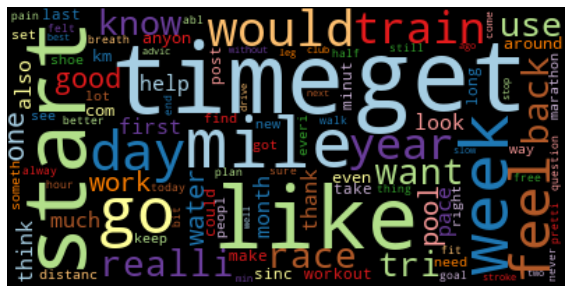

In [71]:
common_words = pd.DataFrame(X_train_features.toarray(), columns = vocab).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=100,
                      background_color="black",
                      colormap='Paired')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Creating a Base Logit Model  

In [23]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(X_train_features, y_train)

# Evaluate model on training data.
print('Accuracy score for Train data set:',lr.score(X_train_features, y_train))

# Evaluate model on testing data.
print('Accuracy score for Test data set:', lr.score(X_test_features, y_test))

Accuracy score for Train data set: 0.9983333333333333
Accuracy score for Test data set: 0.8566666666666667


In [24]:
preds = lr.predict(X_test_features)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print('Specificity:', round(tn / (tn + fp),4))
print('Sensitivity:', round(tp / (tp + fn),4))

Specificity: 0.8333
Sensitivity: 0.88


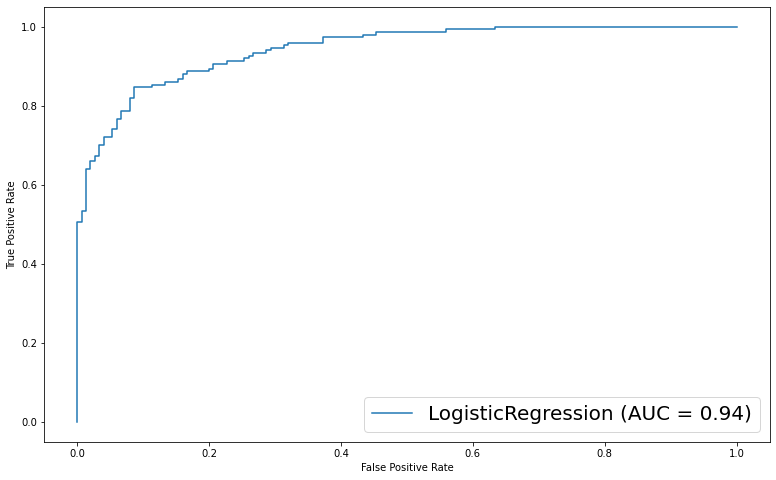

In [25]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(lr, X_test_features, y_test, ax = ax)
plt.legend(prop={"size":20});

***
# Using Different Transformers With Logit Regression

## CountVectorizer Logistic Regression

In [26]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [.5 , .6, .7],
    'cvec__ngram_range': [(1,1), (1,2)]
}

gs_cvec_lr = GridSearchCV(cvec_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train_text, y_train)
cvec_test_time = time() - t0
print('Best CVEC Parameters:', gs_cvec_lr.best_estimator_[0])
print('Fit time:  %0.3fs' % cvec_test_time);

Best CVEC Parameters: CountVectorizer(max_df=0.5, max_features=3000, min_df=5)
Fit time:  43.893s


## TFIDVectorizer Logistic Regression

In [27]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [3000, 4000, 5000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3, .4],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train_text, y_train)
tfid_test_time = time() - t0
print('Best TFID Parameters:',gs_tfid_lr.best_estimator_[0])
print('Fit time:  %0.3fs' % tfid_test_time);

Best TFID Parameters: TfidfVectorizer(max_df=0.3, max_features=3000, min_df=5)
Fit time:  39.110s


## HashingVectorizer Logistic Regression

In [28]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [1000, 2000, 3000, 4000, 5000],
    'hash__ngram_range': [(1,1), (1,2)]
}

gs_hash_lr = GridSearchCV(hash_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train_text, y_train)
hash_test_time = time() - t0
print('Best HASH Parameters:', gs_hash_lr.best_estimator_[0])
print('Fit time:  %0.3fs' % hash_test_time);

Best HASH Parameters: HashingVectorizer(n_features=5000)
Fit time:  5.425s


# R2 Scores & ROC AUC Plot of Different Vectorizers with Logit

In [29]:
print('CVEC LogReg Train Score:', gs_cvec_lr.best_score_)
print('CVEC LogReg Test Score:', gs_cvec_lr.score(X_test_text,y_test))
print('CVEC Fit Time:', cvec_test_time)
print('-'*5)
print('TFID LogReg Train Score:', gs_tfid_lr.best_score_)
print('TFID LogReg Test Score:', gs_tfid_lr.score(X_test_text,y_test))
print('TFID Fit Time:', tfid_test_time)
print('-'*5)
print('HASH LogReg Train Score:', gs_hash_lr.best_score_)
print('HASH LogReg Test Score:', gs_hash_lr.score(X_test_text,y_test))
print('HASH Fit Time:', hash_test_time)

CVEC LogReg Train Score: 0.8799999999999999
CVEC LogReg Test Score: 0.8566666666666667
CVEC Fit Time: 43.89326548576355
-----
TFID LogReg Train Score: 0.9058333333333334
TFID LogReg Test Score: 0.9
TFID Fit Time: 39.109928131103516
-----
HASH LogReg Train Score: 0.8800000000000001
HASH LogReg Test Score: 0.86
HASH Fit Time: 5.424582004547119


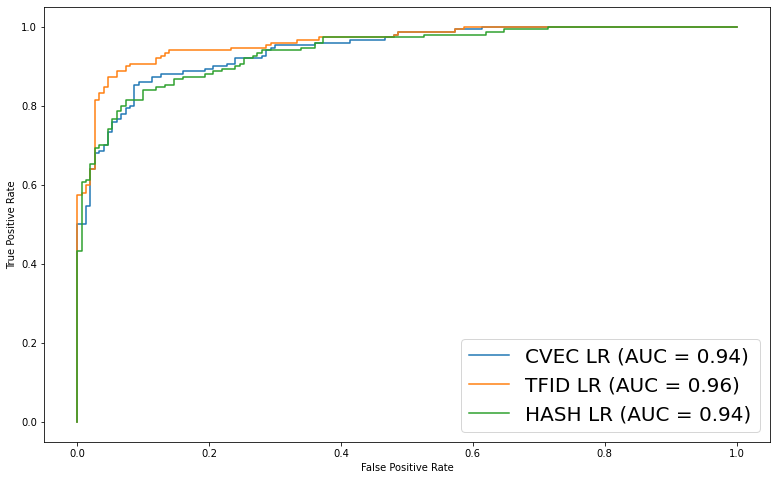

In [30]:
fig, ax = plt.subplots(figsize=(13, 8))
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, X_test_text, y_test, name = 'CVEC LR', ax = ax)
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test_text, y_test, name = 'TFID LR', ax = ax)
hash_lr_disp = plot_roc_curve(gs_hash_lr, X_test_text, y_test, name = 'HASH LR', ax = ax)
plt.legend(prop={"size":20});

# Testing a Combination of TF-IDF and Alternative Models


## TFIDVectorizer KNeighborsClassifier

In [32]:
# Setting pipeline for two stages
tfid_knn = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [10,15],
    'knn__p': [1,2]
}

gs_tfid_knn = GridSearchCV(tfid_knn, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_knn.fit(X_train_text, y_train)
knn_test_time = time() - t0
print('Best KNN Parameters:', gs_tfid_knn.best_estimator_)
print('Fit time:  %0.3fs' % knn_test_time);

Best KNN Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=2000, min_df=3)),
                ('knn', KNeighborsClassifier(n_neighbors=10))])
Fit time:  61.898s


## TFIDVectorizer MultinomialNB

In [33]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [1000,2000,3000],
    'tfid__min_df': [1, 2, 3],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0.1,1,5))
}

gs_tfid_nb = GridSearchCV(tfid_nb, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_nb.fit(X_train_text, y_train)
nb_test_time = time() - t0
print('Best NB Parameters:', gs_tfid_nb.best_estimator_)
print('Fit time:  %0.3fs' % nb_test_time);

Best NB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.325))])
Fit time:  167.282s


## TFIDVectorizer DecisionTreeClassifier

In [34]:
# Setting pipeline for two stages
tfid_cart = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('cart', DecisionTreeClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.3, .4],
    'tfid__ngram_range': [(1,1), (1,2)],
    'cart__min_samples_split': [100 ,200, 300],
    'cart__ccp_alpha': [0, 0.001]
}

gs_tfid_cart = GridSearchCV(tfid_cart, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_cart.fit(X_train_text, y_train)
cart_test_time = time() - t0
print('Best CART Parameters:', gs_tfid_cart.best_estimator_)
print('Fit time:  %0.3fs' % cart_test_time);

Best CART Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=1000, min_df=2)),
                ('cart',
                 DecisionTreeClassifier(ccp_alpha=0, min_samples_split=100))])
Fit time:  84.889s


## TFIDVectorizer BaggingClassifier

In [35]:
# Setting pipeline for two stages
tfid_bag = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('bag', BaggingClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000],
    'tfid__min_df': [2, 3, 4],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_bag = GridSearchCV(tfid_bag, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_bag.fit(X_train_text, y_train)
bag_test_time = time() - t0
print('Best BAG Parameters:', gs_tfid_bag.best_estimator_)
print('Fit time:  %0.3fs' % bag_test_time);

Best BAG Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=2000, min_df=2,
                                 ngram_range=(1, 2))),
                ('bag', BaggingClassifier())])
Fit time:  115.007s


## TFIDVectorizer ADABoostClassifier

In [36]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.3, .4],
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [0.9, 1]
}

gs_tfid_ada = GridSearchCV(tfid_ada, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train_text, y_train)
ada_test_time = time() - t0
print('Best ADABoost Parameters:', gs_tfid_ada.best_estimator_)
print('Fit time:  %0.3fs' % ada_test_time);

Best ADABoost Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000, min_df=3)),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.9, n_estimators=100))])
Fit time:  99.577s


### R2 Scores & ROC AUC Plots of the Models

In [37]:
print(f'TFID LogReg Train Score:', gs_tfid_lr.best_score_)
print(f'TFID LogReg Test Score:', gs_tfid_lr.score(X_test_text,y_test))
print(f'LogReg Fit Time:', tfid_test_time)
print('-'*5)
print(f'TFID KNN Train Score:', gs_tfid_knn.best_score_)
print(f'TFID KNN Test Score:', gs_tfid_knn.score(X_test_text,y_test))
print(f'KNN Fit Time:', knn_test_time)
print('-'*5)
print(f'TFID NB Train Score:', gs_tfid_nb.best_score_)
print(f'TFID NB Test Score:', gs_tfid_nb.score(X_test_text,y_test))
print(f'NB Fit Time:', nb_test_time)
print('-'*5)
print(f'TFID CART Train Score:', gs_tfid_cart.best_score_)
print(f'TFID CART Test Score:', gs_tfid_cart.score(X_test_text,y_test))
print(f'CART Fit Time:', cart_test_time)
print('-'*5)
print(f'TFID BAG Train Score:', gs_tfid_bag.best_score_)
print(f'TFID BAG Test Score:', gs_tfid_bag.score(X_test_text,y_test))
print(f'BAG Fit Time:', bag_test_time)
print('-'*5)
print(f'TFID ADABoost Train Score:', gs_tfid_ada.best_score_)
print(f'TFID ADABoost Test Score:', gs_tfid_ada.score(X_test_text,y_test))
print(f'ADABoost Fit Time:', ada_test_time)

TFID LogReg Train Score: 0.9008333333333333
TFID LogReg Test Score: 0.9
LogReg Fit Time: 40.07628321647644
-----
TFID KNN Train Score: 0.8666666666666666
TFID KNN Test Score: 0.8433333333333334
KNN Fit Time: 61.89807748794556
-----
TFID NB Train Score: 0.9041666666666666
TFID NB Test Score: 0.9033333333333333
NB Fit Time: 167.28163027763367
-----
TFID CART Train Score: 0.8333333333333334
TFID CART Test Score: 0.82
CART Fit Time: 84.88855314254761
-----
TFID BAG Train Score: 0.8616666666666667
TFID BAG Test Score: 0.8333333333333334
BAG Fit Time: 115.0074098110199
-----
TFID ADABoost Train Score: 0.8608333333333335
TFID ADABoost Test Score: 0.81
ADABoost Fit Time: 99.57707691192627


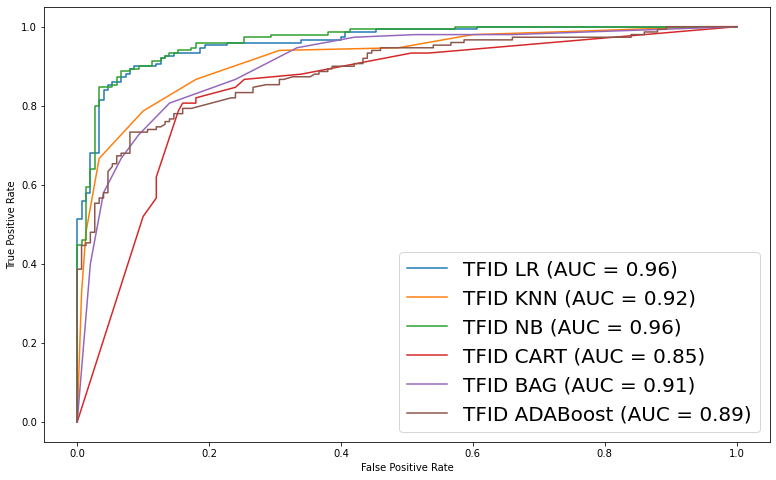

In [38]:
fig, ax = plt.subplots(figsize=(13, 8))
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test_text, y_test, name = 'TFID LR', ax = ax)
tfid_knn_disp = plot_roc_curve(gs_tfid_knn, X_test_text, y_test, name = 'TFID KNN', ax = tfid_lr_disp.ax_)
tfid_nb_disp = plot_roc_curve(gs_tfid_nb, X_test_text, y_test, name = 'TFID NB', ax = tfid_lr_disp.ax_)
tfid_cart_disp = plot_roc_curve(gs_tfid_cart, X_test_text, y_test, name = 'TFID CART', ax = tfid_lr_disp.ax_)
tfid_bag_disp = plot_roc_curve(gs_tfid_bag, X_test_text, y_test, name = 'TFID BAG', ax = tfid_lr_disp.ax_)
tfid_ada_disp = plot_roc_curve(gs_tfid_ada, X_test_text, y_test, name = 'TFID ADABoost', ax = tfid_lr_disp.ax_)
plt.legend(prop={"size":20});

***
# What is the confusion matrix of the Logit Model?

In [73]:
predictions = gs_tfid_lr.predict(X_test_text)

In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print('Accuracy of running prediction:', round(tp / (tp + fn),4))
print('Accuracy of swimmning prediction:', round(tn / (tn + fp),4))

True Negatives: 135
False Positives: 15
False Negatives: 15
True Positives: 135
Sensitivity, Accuracy of Thread 1: 0.9
Specificity, Accuracy of Thread 2: 0.9


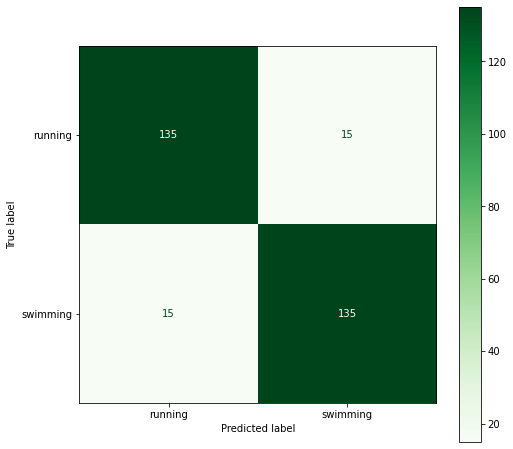

In [41]:
# Plot a confusion matrix. The greener the square, the better the result.
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(gs_tfid_lr, X_test_text, y_test, ax = ax,cmap='Greens')

The model was quite accurate! To investigate where it went wrong, we will examine incorrectly identified posts later below.
We might reasonably expect that when words directly related to both subreddits are included (running and swimming lemmas), accuracy increases to almost 100%

***
# Wordclouds

In [42]:
def fancycloud(targetimage, color, invert=False, bg="black"):
    # Create a dataframe containing the words and their coefficient
    wordcloudcontent = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = invert).reset_index(drop = True)
    if invert == True:
        wordcloudcontent['Coef'] = wordcloudcontent['Coef']*-1

    # Create a dictionary where the word is the key and the coefficient is the associated value   
    freq = {}
    for i,j in wordcloudcontent.values:
        freq[i] = j
    
    # Create a mask using an image (preferably a black and white vector graphic)
    mask = np.array(Image.open(targetimage))
    
    # Generate a wordcloud function
    wordcloud = WordCloud(max_font_size=100,
                      max_words=200,
                      background_color=bg,
                      colormap=color,
                      mask = mask)
    
    # Call the function using the frequencies
    wordcloud.generate_from_frequencies(frequencies=freq)
    
    plt.figure(figsize = (14,14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [43]:
runimage = '../images/run.jpg'
swimimage = '../images/swim.jpg'

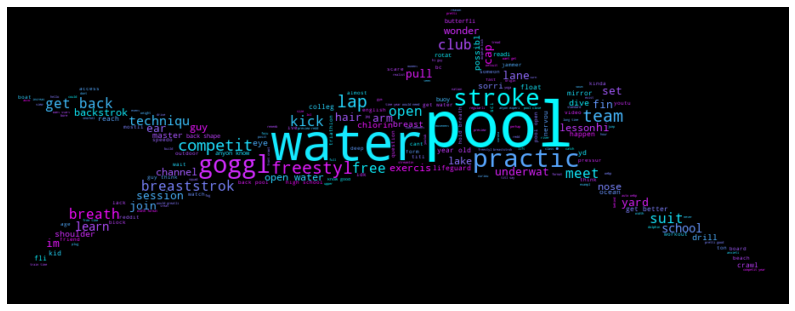

In [44]:
fancycloud(swimimage, 'cool')

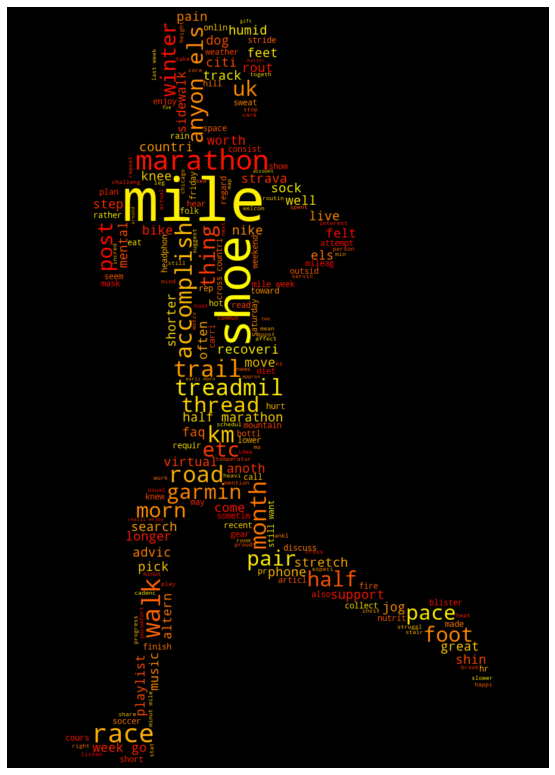

In [45]:
fancycloud(runimage, 'autumn',invert=True)

# Visualising the most important words for predicting each subreddit


In [46]:
def barplotter(title, colors,invert=False):
    # Create a dataframe containing the words and their coefficient
    wordcloudcontent = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = invert).reset_index(drop = True)
    if invert == True:
        wordcloudcontent['Coef'] = wordcloudcontent['Coef']*-1
    plt.figure(figsize= (10, 6))
    plt.title(title,fontdict = {'fontsize':25})
    sns.barplot(x= wordcloudcontent['Coef'][:25], y=wordcloudcontent['Features'][:25], palette=colors)
    plt.show()

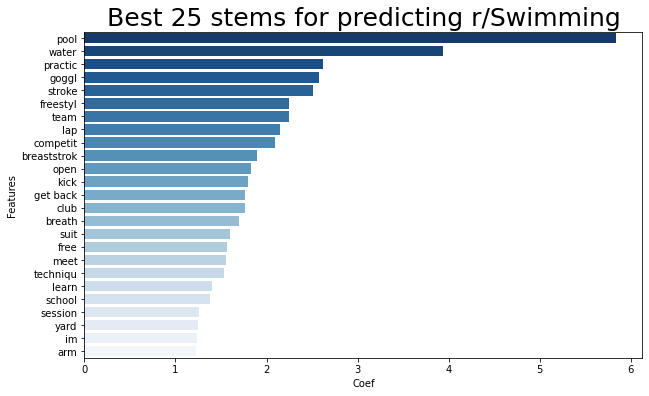

In [47]:
barplotter('Best 25 stems for predicting r/Swimming', colors='Blues_r')

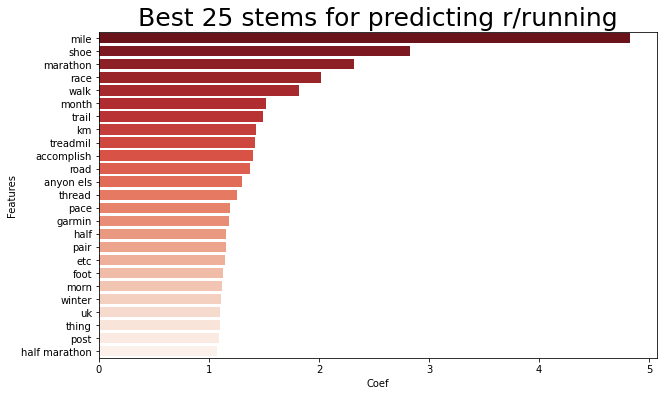

In [48]:
barplotter('Best 25 stems for predicting r/running', colors='Reds_r',invert=True)

Many words one might reasonably expect to see in discussions of swimming and running appear in these graphs
Words that might apply to both swimming and running such as “lap” might still be more strongly associated with one sport 
The words might also represent elements of user demographics:
Note that "school" appeared associated with swimming and "uk" appeared associated with r running. These associations would be problematic in a general use model! Their presence however does suggest something about the userbase of each subreddit.

# Examining the misclassified posts

In [75]:
# Create a dataframe of the predictions from the chosen model
predictedposts = pd.DataFrame(gs_tfid_lr.predict(X_test_text), columns=['pred'], index = y_test.index)

# Add in a column with the actual subreddit of the post
predictedposts['actual'] = y_test

# Indentify the indexes of posts that were mispredicted
row_ids = predictedposts[predictedposts['pred']!= predictedposts['actual']].index
row_ids.values

array([1031,  965,  686, 1052,  435,  492,  700,  933,  661, 1143,  783,
       1453, 1329,  372,  134,  635,  944,   13,   14,  796, 1269,  556,
        201,  810,  230,   80,  106, 1099, 1327,  764], dtype=int64)

In [50]:
# What does the text of swimming posts that were classified as running posts look like?
for i in row_ids.values:
    if i >= 750:
        print('Post title:',df['title'][i])
        print(df['selftext'][i],'\n')
        print('-'*20,'\n')

Post title: Recommendations on good hybrid swim trunks/running shorts?
I had some good luck around 10 years ago, where I found some swim trunks that were labeled as hybrid running shorts as well. They were just shorter swim trunks, with more pockets, and made of swim trunk quick dry material. They have finally died. Fully disintegrated. Due to COVID, I don't feel like going into stores and finding or trying on some new stuff or figuring out what is out there. There seem to be tons of options through literally all of the outlets, and it is overwhelming. 



So does anybody have a pair of running shorts that double as swim trunks (vice versa) that they would recommend? 

-------------------- 

Post title: I think I want to quit.
I’ve been swimming competitively for about 7 years and I’m starting to burn out harder than I have before. I recently have come back to swimming after being out for 8months due to a back injury. I’ve been back swimming for about 3 weeks and I dread getting up and

In [53]:
# What does the text of running posts that were classified as swimming posts look like?
for i in row_ids.values:
    if i < 750:
        print('Post title:',df['title'][i])
        print(df['selftext'][i],'\n')
        print('-'*20,'\n')

Post title: I ran a marathon on a 400m track (105,5 laps)
[https://www.strava.com/activities/4009431190](https://www.strava.com/activities/4009431190)

**Distance: 42,2km**

**Time: 03:54:33**

**Backstory:** Stockholm Marathon was cancelled this year and they compensated runners with moving the ticket to 2021 and getting the Stockholm Virtual Run for free, so if you run a marathon between 4.9-6.9.2020 you get a t-shirt and medal. The idea of just running a marathon in Helsinki seemed a bit lack lustering so I decided to spice it up by doing 105,5 laps on the local track field. I always found track and treadmill running a bit boring since the scenery is the same, so I knew this was going to be a real challenge.

**Training:** Jogger from Finland with 1,5 years of running experience. Two weeks prior to this I ran a personal best on Helsinki Marathon (03:37:31), and I’ve been hitting a record high mileage for the past couple of weeks. I was not ready for another marathon.

**Location:** 

### Interesting misclassified posts:
Interesting misclassified swimming posts:
   
    Ah man that was GOOD. Had a double width lane to myself the entire time. Swam for 45 mins and did a little over 2km. Impressed myself!
    And I don't feel like I've been hit by a car. I think I'll have to put in more effort next time :-) 

From the word coefficients of running, it seems runners are more likely to complain about traffic. The usage of the word car here likely caused the model to misclassify the post.

    Hello, I swim 1.5km (almost a mile) once or twice a week in summer, and I've struggled to put together a dry land training regime to help me improve my time/fitness (let's ignore my form for  the moment).
    I've got access to a gym now with a full weights set and cardio machines (treadmill, bike, rowing machines).  Can anyone give me some pointers on what to start on for a dry land program (or even some bodyweight program work) to help my swimming fitness / strength?  If you are comfortable sharing your program it would be greatly appreciated.

This user, although posting in swimming, was engaging in a primarily land based discussion, with his talk about gym equipment and land based cardio. Although it represents a misclassification by the model, in a deployment situation where the model recommends that this user be given links to running paraphernalia, the recommendation would be correct.

Interesting misclassified running posts:

    If you go for a run in the morning and if you take supplements, do you usually take them before your run or after? I get up at 7am for a 7:30am run. I tried taking them before my run, but there is no way I can drink 16oz of water with it right before I run.

The user used the word run a lot, which was filtered, but also spoke about water, which was strongly strongly correlated with swimming, resulting in the misclassification.

    Hi everyone, I am a high school student who recently just tried out for the cross country team. I was the only U19, which means I made the team automatically, but I did terrible at the tryouts (ran less laps than the U14s) and I want your tips and advices on how to get better as a runner, as well as the amount of time that I need to commit each week. 
    I am worried that I won't have enough time to train (the tournament is on December) and am even thinking about whether I should just drop the team or not... 

This misclassification is the result of the model incorrectly associating school more strongly with high schools and colleges.

It appears that misclassified posts mostly had words that would still identify them, but were filtered during stemming, such as runner and swimmer. These posts also lacked the identifying words that appeared in our 25 most useful stems for their respective correct subreddits. Interestingly, some words contained a mixture of words that would have strongly identified them as their correct subreddit but were filtered, and words that identified them incorrectly which had a high coefficient for the other subreddit. An example is the post "When do you take supplements..." which contains the word "run" several times (a filtered word) and the word "water" in the context of drinking, which is a strong identifier for the swimming subreddit instead.

# Conclusion and Comments

### Limitations
The posts available to the model are reflective of the demographics of their respective userbases

Swimming is more niche and there are many more posts about technique and competing

It also appears to have many more young athletes as a percentage of the user base

Running has more hobby runners and the discussion topics are broader and less focused

The model is currently only being tested on the source communities

Testing on different communities and different demographics might cause the model accuracy to drop significantly

Demographic concerns include both reddit as a whole and the respective subreddit user bases

Active posters on reddit tend to be much more likely to be below 30

Given that Logistic Regression can only make predictions between two classes, accuracy and the necessity of using a model capable of multiple category classification will decrease in broader applications


### Further Considerations
The results from this project show promise for classifying the word content of user posts into a useful prediction system

The application will be even more applicable with additional training, additional subjects as well as some method for interaction terms (that I have not learned yet)

For example: kick + lap probably indicates swimming technique, kick + gait probably indicates a discussion about running technique, kick + pads probably indicates a kickboxing discussion, 

Further controls for communities or training on local data from the target communities would improve accuracy. 
